# Support Vector Machine Exercise
In this exercise you will learn about:
1. Implementing SVM from scratch using a sub-gradient method called Pegasos (2011)
2. The effect of imbalance and non-seperable classes on the SVM solution.
3. Pratical SVM in scikit-learn on a simple example including hyper parameter optimization wrapper class to find optimal regularization, loss and multiclass technique.
4. Optional reading material on one class, new probability interpretation of SVM

## 1. Implementing the PEGASOS SVM (55 points)
We will implement the simplest SVM implementation. 
It is based on a paper by Shalev-Shwartz et al (see reading material below).
The essense of the algorithm is copied below from the paper:
![alt text](https://snag.gy/Gpi1Mk.jpg)

Here is a little more deailed explanation (it's recommended to read the full paper).
![alt_text](https://snag.gy/koA0ue.jpg)


1. Implement a class *PegasosSVM* which has parameter $\lambda$ and $T$ and methods *fit* and *predict* and *decision_function* where the latter is the distance from the plane (aka model's output score).
  * **although the above**, here you are required to pad the samples with 1, and not use bias (the separating hyperplane must go through the origin).
  * don't forget labels should be {-1,1} - change them if it is {0,1}
  * don't forget to normalize your features. You can use [StandardScaler](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.StandardScaler.html) and [Pipeline](https://scikit-learn.org/stable/modules/generated/sklearn.pipeline.Pipeline.html) to create a pipeline which first standartize features and then learn.

2. test your class on the breast cancer database [load_breast_cancer](https://scikit-learn.org/stable/modules/generated/sklearn.datasets.load_breast_cancer.html), and compare your results to the Native Scikit-learn implementation [LinearSVC](https://scikit-learn.org/stable/modules/generated/sklearn.svm.LinearSVC.html#sklearn.svm.LinearSVC)
  * you can use [`cross_val_score`](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.cross_val_score.html)

3. Analyze the effect of the hyper parameter $\lambda$ on your training and test error. 
  * you can use scikit-learn's `validation_curve`

4. Analyze the learning curve (performance as function of training size)
  * you can use scikit-learn's `learning_curve`

5. *Bonus: Mini-batches* . In the paper, the authors summed the loss over several samples before updating. Extend your class to support mini-batches and analyze the perfomance effect if exists. See more details below

![](https://i.ibb.co/0BGwVz7/1.png)

In [25]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

## Prepare data

In [2]:
from sklearn.datasets import load_breast_cancer
X,y = load_breast_cancer(True)

y[y==0]=-1

X=np.hstack((X,np.ones([X.shape[0],1], X.dtype)))


## class PegasosSVM

In [3]:
class PegasosSVM:
    def fit(self,X,y,lam=.01,T=2000):
        self.w=np.zeros_like(X[0])
        for t in range(1,T):
            eta= 1/(lam*t)
            sample = np.random.randint(len(y))
            x=X[sample]
            if y[sample]*np.dot(self.w,x)<1:
                self.w=(1-eta*lam)*self.w+eta*y[sample]*x
            else:
                self.w=(1-eta*lam)*self.w
    def predict(self,X):
        return np.sign(np.sum(self.w*X, axis=-1))  
    def score(self,X,y):
        return np.mean(np.sign(np.sum(self.w*X, axis=-1))==y)
    def decision_function(self,X):
        return np.sum(self.w*X, axis=-1)

In [4]:
class PegasosSVM_mb:
    def fit(self,X,y,lam=.01,T=2000,mb=10):
        self.w=np.zeros_like(X[0])
        for t in range(1,T):
            eta= 1/(lam*t)
            sample = np.random.choice(len(y),size=mb,replace=False)
            x=X[sample]
            samples_to_update = y[sample]*np.sum(self.w*x, axis=-1)<1
            self.w=(1-eta*lam)*self.w+eta*np.dot(y[sample][samples_to_update],x[samples_to_update])
    def predict(self,X):
        return np.sign(np.sum(self.w*X, axis=-1))  
    def score(self,X,y):
        return np.mean(np.sign(np.sum(self.w*X, axis=-1))==y)
    def decision_function(self,X):
        return np.sum(self.w*X, axis=-1)

In [5]:
# Done in a way which allows us to do optimization with the sklearn toolkit
class sklearn_pegasos():

    def __init__(self, lam=.01,T=2000):
        self.lam = lam
        self.T=T

    def fit(self,X,y):
        self.w=np.zeros_like(X[0])
        for t in range(1,self.T):
            eta= 1/(self.lam*t)
            sample = np.random.randint(len(y))
            x=X[sample]
            if y[sample]*np.dot(self.w,x)<1:
                self.w=(1-eta*self.lam)*self.w+eta*y[sample]*x
            else:
                self.w=(1-eta*self.lam)*self.w
    def predict(self,X):
        return np.sign(np.sum(self.w*X, axis=-1))  
    def score(self,X,y):
        return np.mean(np.sign(np.sum(self.w*X, axis=-1))==y)
    def decision_function(self,X):
        return np.sum(self.w*X, axis=-1)
    def get_params(self, deep=True):
        return {"lam": self.lam, "T": self.T}

    def set_params(self, **parameters):
        for parameter, value in parameters.items():
            setattr(self, parameter, value)
        return self

In [6]:
clf = PegasosSVM()
clf.fit(X,y)
clf.predict(X)
clf.score(X,y)

0.8822495606326889

In [7]:
clf = PegasosSVM_mb()
clf.fit(X,y)
clf.predict(X)
clf.score(X,y)

0.687170474516696

## Standardize, score, and compare to linearSVM

In [8]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                    random_state=0)
pipe = Pipeline([('scaler', StandardScaler()), ('pegasos', PegasosSVM())])
pipe.fit(X_train, y_train)
pipe.score(X_test,y_test)



0.965034965034965

In [9]:
from sklearn.svm import LinearSVC

pipe_svm = Pipeline([('scaler', StandardScaler()), ('svm', LinearSVC(max_iter=2000))])
pipe_svm.fit(X_train, y_train)
pipe_svm.score(X_test,y_test)


0.9440559440559441

In [10]:
from sklearn.model_selection import cross_val_score as cv
np.mean(cv(pipe,X,y,cv=10)),np.mean(cv(pipe_svm,X,y,cv=10))
#Our implementation outperforms sklearn's

(0.9647556390977444, 0.9720184080891885)

## hyperparamater optimization

In [11]:
import pandas as pd

max lambda at: lam      0.13895
score    0.64000
Name: 35, dtype: float64


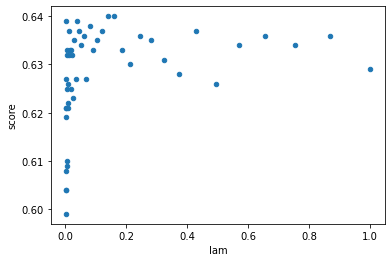

In [21]:
score=list()
for lam in np.logspace(-3,0):
    pipe = Pipeline([('scaler', StandardScaler()), ('pegasos', sklearn_pegasos(lam))])
    score.append([lam,np.mean(cv(pipe,X,y,cv=10,))])
df=pd.DataFrame(score,columns=['lam','score'])
print("max lambda at:",df[df.score==df.score.max()].iloc[0,:])
pd.DataFrame(score,columns=['lam','score']).plot.scatter('lam','score')

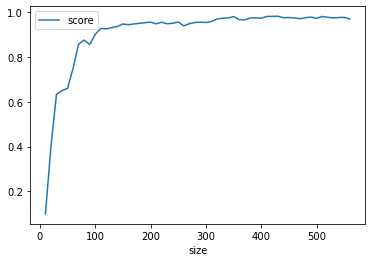

In [13]:
score=list()
lam=.3
for size in np.arange(10,len(y),step=10):
    pipe = Pipeline([('scaler', StandardScaler()), ('pegasos', sklearn_pegasos(lam))])
    score.append([size,np.mean(cv(pipe,X[:size],y[:size],cv=10))])
df=pd.DataFrame(score,columns=['size','score'])
df.plot.line('size','score')

## 2. The importance of class weighting in SVM (15)
When classes are imbalance and not seperable, SVM might result in non intuitive solution.

To see this create a function `make_data` which generates a two dimensional dataset with `n_samples=1000` where a fraction `imbalance=0.1` is labeled `0` and the rest `1`. The distribution of $x$ given $y=0$ or $y=1$ is gaussian with std 0.5 or 2, respectively and that the centers are at $x_1=0$ and $x_2=-d/2$ and $x_2=d/2$, respectively. In other words,  
$$
p(x|y) = \mathcal{N}(\mu=(±d/2,0),\,\sigma=1/2+3/2\times y)
$$
and 
$$
p(y=0) = 0.1
$$. 

* For `d=10` and `d=2` plot the scatter plot of the data. Where would you think the SVM hyperplane will lie?

* Now, for each of these d, draw on top of the scatter the seperation hyperplane of the built-in LinearSVC in scikit-learn.

To plot the hyperplane, note that the fitted model has the `coef_` and `intercept_` properties.
Add also the `accuracy` and the `balanced_accuracy` metrics to the plot title.

* repeat the experiment but now set the `class_weight` to be `balanced`. 

Explain what was the problem and how changing class weight solved it.


In [14]:
n_samples=1000
d=2
def make_data(d,n_samples):
    y=np.random.binomial(1,p=.9,size=n_samples)
    normal0 = np.random.multivariate_normal([0,-d/2],np.eye(2)*.5**2,size=n_samples)
    normal1 = np.random.multivariate_normal([0,d/2],np.eye(2)*2**2,size=n_samples)
    normal1[y==0]=normal0[y==0]
    X=normal1
#     X=np.vstack([normal1[:,0]*y,normal1[:,1]*y]).T+np.vstack([normal0[:,0]*(1-y),normal0[:,1]*(1-y)]).T
    return X,y

In [15]:
X,y = make_data(10,1000)

In [20]:
from sklearn.metrics import balanced_accuracy_score

from sklearn.metrics import accuracy_score
import seaborn as sns


In [17]:
def abline(slope, intercept):
    """Plot a line from slope and intercept"""
    axes = plt.gca()
    x_vals = np.array(axes.get_xlim())
    y_vals = intercept + slope * x_vals
    plt.plot(x_vals, y_vals, '--')

In [26]:
def plot_svm(d,balanced):
    X,y = make_data(d,1000)
    svm=LinearSVC(class_weight=balanced)
    svm.fit(X,y)
    coef1 = svm.coef_[0][0]
    coef2 = svm.coef_[0][1]
    sns.scatterplot(X[:,0],X[:,1],c=y)
    abline(-coef1/coef2,-svm.intercept_/coef2)
    title = 'd='+str(d)+',accuracy='+str(accuracy_score(svm.predict(X),y))+',balanced accuracy'+str(balanced_accuracy_score(svm.predict(X),y))
    plt.title(title)
    plt.plot()

C:\Users\jjlev\AppData\Local\Continuum\anaconda3\lib\site-packages\seaborn\_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
C:\Users\jjlev\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1745: UserWarning: y_pred contains classes not in y_true
  warnings.warn('y_pred contains classes not in y_true')


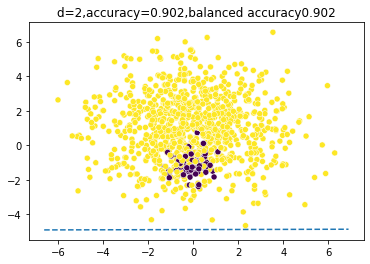

In [27]:
plot_svm(2,None)

C:\Users\jjlev\AppData\Local\Continuum\anaconda3\lib\site-packages\seaborn\_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


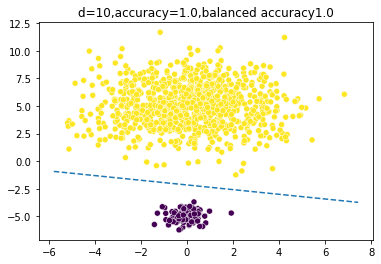

In [28]:
plot_svm(10,None)

C:\Users\jjlev\AppData\Local\Continuum\anaconda3\lib\site-packages\seaborn\_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


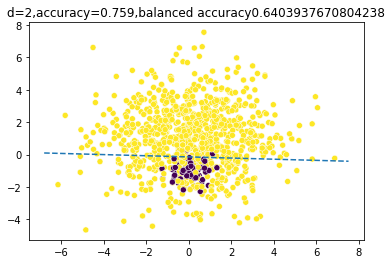

In [29]:
plot_svm(2,'balanced')

C:\Users\jjlev\AppData\Local\Continuum\anaconda3\lib\site-packages\seaborn\_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


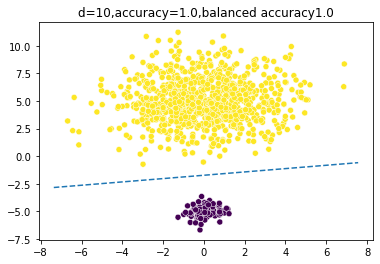

In [30]:
plot_svm(10,'balanced')

The problem was that the support vectors chosen for the imbalanced data set mostly included the majority class and ignored the minority class.  That is why we see the hyperplane all the way below the bottom of the data in the case where d=2 - because that is the solution that maximizes the svm margin for the majority class.
When we used balanced data, the svm uses an equal number of points from either data set, thus it puts the hyperplane in a place that takes into account points from both data sets.

## 3. SVM hyperparameter search (10)
Machine learning pipelines in general and models in particular has several hyperparametrs that we currently do not know how to optimize.
Instead, researcher use grid search or random search techniques to find the optimal hyper parameters.
In this exercise you are requested to compare between default params model and a model which internally optimize for these hyper parameters.
Luckily, scikit-learn already has a ready class for doing that called `GridSearchCV`. Use the latter class to check all the combination of the following hyper parameters:
* `'multi_class':['ovr', 'crammer_singer']`
* `'loss':['hinge', 'squared_hinge']`
* `'C': np.logspace(-3,3,10)`

Compare the accuracy of the model to a default `LinearSVC` model with no hyper parameter optimization in terms of accuracy.

Note: Recall, that hyper parameter search is a learning procedure by itself, thus one should not use test data for the process. 

To do this you can use the handy `cross_val_score` function.


In [31]:
from sklearn.model_selection import GridSearchCV
parameters = {'multi_class':['ovr', 'crammer_singer'],
'loss':['hinge', 'squared_hinge']
,'C': np.logspace(-3,3,10)}

svc = LinearSVC(max_iter=2000)
clf = GridSearchCV(svc, parameters)
X,y = load_breast_cancer(True)
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                    random_state=0)

clf.fit(X_train, y_train)


C:\Users\jjlev\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\model_selection\_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)
C:\Users\jjlev\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\svm\base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
C:\Users\jjlev\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\svm\base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
C:\Users\jjlev\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\svm\base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
C:\Users\jjlev\AppData\Local\Continuum\

C:\Users\jjlev\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\svm\base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
C:\Users\jjlev\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\svm\base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
C:\Users\jjlev\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\svm\base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
C:\Users\jjlev\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\svm\base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
C:\Users\jjlev\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\svm\base.py:9

C:\Users\jjlev\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\svm\base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
C:\Users\jjlev\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\svm\base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
C:\Users\jjlev\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\svm\base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
C:\Users\jjlev\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\svm\base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
C:\Users\jjlev\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\svm\base.py:9

C:\Users\jjlev\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\svm\base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
C:\Users\jjlev\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\svm\base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
C:\Users\jjlev\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\svm\base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
C:\Users\jjlev\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\svm\base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
C:\Users\jjlev\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\svm\base.py:9

GridSearchCV(cv='warn', error_score='raise-deprecating',
             estimator=LinearSVC(C=1.0, class_weight=None, dual=True,
                                 fit_intercept=True, intercept_scaling=1,
                                 loss='squared_hinge', max_iter=2000,
                                 multi_class='ovr', penalty='l2',
                                 random_state=None, tol=0.0001, verbose=0),
             iid='warn', n_jobs=None,
             param_grid={'C': array([1.00000000e-03, 4.64158883e-03, 2.15443469e-02, 1.00000000e-01,
       4.64158883e-01, 2.15443469e+00, 1.00000000e+01, 4.64158883e+01,
       2.15443469e+02, 1.00000000e+03]),
                         'loss': ['hinge', 'squared_hinge'],
                         'multi_class': ['ovr', 'crammer_singer']},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring=None, verbose=0)

In [32]:
clf.best_params_

{'C': 10.0, 'loss': 'hinge', 'multi_class': 'crammer_singer'}

In [33]:
svc=LinearSVC()
svc.fit(X_train,y_train)
print("with no optimization we get:",svc.score(X_test,y_test))
print("with optimization we get:",clf.score(X_test,y_test))


with no optimization we get: 0.9440559440559441
with optimization we get: 0.965034965034965


C:\Users\jjlev\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\svm\base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


## 4. Classifying Checkerboard with SVM (20)
In this exercise you will try to choose a kernel for classifying a checkerboard labeled data. 

* Use the `checkboard` function below to generate
your training set (1000 or 2000 samples) and a testing set (as much as you like). As you can see the function generates samples in 2D and label them according to a 3 × 3 checkerboard (obviously linear separation will not do the job here). Python’s scatter in the might come in handy.

* Use SVM to find a good linear separation in high dimensional feature space using the polynomial or the Gaussian (RBF) kernel.    You should evaluate for both models the best parameters to use. Explain how do you evalute each model?
   - For polynomial kernel, estimate which degree to use
   - For RBF, estimate which standard deviation to use
   - For both models, also choose which regularization parameter is best to use
 
* For the best model of each kernel, plot a scatter plot of the training patterns (colored by label) and mark the support vectors as well. Which model would you choose to use in this case?

* In addition, if you are curious, you can try and think of a way to plot the separating hyper-surface (curve in this case), the margin, and the testing set (to check which points are misclassified).

In [34]:
import numpy as np
def checkerboard(n):
    """
    CHECKERBOARD Sample points from a 3x3 checkerboard in 2D
    """
    X = np.random.rand(n,2); # samples dimension N = 2
    l = np.mod(np.ceil(X*3), 2);
    y0 = np.logical_xor(l[:,0], l[:,1])
    y = y0*2-1 # {-1,+1}
    return X, y

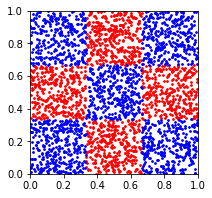

In [35]:
# Usage sample
import matplotlib.pyplot as plt
X, y = checkerboard(3000)
plt.figure(figsize=(3,3))
plt.scatter(X[y==1,0], X[y==1,1], c='r', s=3)
plt.scatter(X[y==-1,0], X[y==-1,1], c='b', s=3)
plt.xlim([0,1])
plt.ylim([0,1]);

In [36]:
from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVC
scaler=StandardScaler()
X_scaled=scaler.fit_transform(X)
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y,
                                                    random_state=0)

parameters = {'gamma':np.logspace(1,6,num=20),'C':np.logspace(-5,0,num=20)}
svc = SVC(max_iter=2000)
clf_rbf = GridSearchCV(svc, parameters)

clf_rbf.fit(X_train, y_train)
clf_rbf.best_params_,clf_rbf.score(X_test,y_test)

C:\Users\jjlev\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\model_selection\_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)
C:\Users\jjlev\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\svm\base.py:241: ConvergenceWarning: Solver terminated early (max_iter=2000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
C:\Users\jjlev\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\svm\base.py:241: ConvergenceWarning: Solver terminated early (max_iter=2000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
C:\Users\jjlev\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\svm\base.py:241: ConvergenceWarning: Solver terminated early (max_iter=2000).  Consider pre-processing your data with St

C:\Users\jjlev\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\svm\base.py:241: ConvergenceWarning: Solver terminated early (max_iter=2000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
C:\Users\jjlev\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\svm\base.py:241: ConvergenceWarning: Solver terminated early (max_iter=2000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
C:\Users\jjlev\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\svm\base.py:241: ConvergenceWarning: Solver terminated early (max_iter=2000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
C:\Users\jjlev\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\svm\base.py:241: ConvergenceWarning: Solver terminated early (max_iter=2000).  Consider pre-processing your data with StandardScaler 

C:\Users\jjlev\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\svm\base.py:241: ConvergenceWarning: Solver terminated early (max_iter=2000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
C:\Users\jjlev\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\svm\base.py:241: ConvergenceWarning: Solver terminated early (max_iter=2000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
C:\Users\jjlev\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\svm\base.py:241: ConvergenceWarning: Solver terminated early (max_iter=2000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
C:\Users\jjlev\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\svm\base.py:241: ConvergenceWarning: Solver terminated early (max_iter=2000).  Consider pre-processing your data with StandardScaler 

C:\Users\jjlev\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\svm\base.py:241: ConvergenceWarning: Solver terminated early (max_iter=2000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
C:\Users\jjlev\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\svm\base.py:241: ConvergenceWarning: Solver terminated early (max_iter=2000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
C:\Users\jjlev\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\svm\base.py:241: ConvergenceWarning: Solver terminated early (max_iter=2000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
C:\Users\jjlev\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\svm\base.py:241: ConvergenceWarning: Solver terminated early (max_iter=2000).  Consider pre-processing your data with StandardScaler 

C:\Users\jjlev\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\svm\base.py:241: ConvergenceWarning: Solver terminated early (max_iter=2000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
C:\Users\jjlev\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\svm\base.py:241: ConvergenceWarning: Solver terminated early (max_iter=2000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
C:\Users\jjlev\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\svm\base.py:241: ConvergenceWarning: Solver terminated early (max_iter=2000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
C:\Users\jjlev\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\svm\base.py:241: ConvergenceWarning: Solver terminated early (max_iter=2000).  Consider pre-processing your data with StandardScaler 

C:\Users\jjlev\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\svm\base.py:241: ConvergenceWarning: Solver terminated early (max_iter=2000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
C:\Users\jjlev\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\svm\base.py:241: ConvergenceWarning: Solver terminated early (max_iter=2000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
C:\Users\jjlev\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\svm\base.py:241: ConvergenceWarning: Solver terminated early (max_iter=2000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
C:\Users\jjlev\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\svm\base.py:241: ConvergenceWarning: Solver terminated early (max_iter=2000).  Consider pre-processing your data with StandardScaler 

({'C': 1.0, 'gamma': 61.58482110660264}, 0.9773333333333334)

In [37]:
parameters = {'degree':np.arange(1,10),'C':np.logspace(-5,0)}
svc = SVC(max_iter=2000,kernel='poly',gamma='auto')
clf_poly = GridSearchCV(svc, parameters,cv=5)

clf_poly.fit(X_train, y_train)


C:\Users\jjlev\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\svm\base.py:241: ConvergenceWarning: Solver terminated early (max_iter=2000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
C:\Users\jjlev\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\svm\base.py:241: ConvergenceWarning: Solver terminated early (max_iter=2000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
C:\Users\jjlev\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\svm\base.py:241: ConvergenceWarning: Solver terminated early (max_iter=2000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
C:\Users\jjlev\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\svm\base.py:241: ConvergenceWarning: Solver terminated early (max_iter=2000).  Consider pre-processing your data with StandardScaler 

C:\Users\jjlev\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\svm\base.py:241: ConvergenceWarning: Solver terminated early (max_iter=2000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
C:\Users\jjlev\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\svm\base.py:241: ConvergenceWarning: Solver terminated early (max_iter=2000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
C:\Users\jjlev\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\svm\base.py:241: ConvergenceWarning: Solver terminated early (max_iter=2000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
C:\Users\jjlev\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\svm\base.py:241: ConvergenceWarning: Solver terminated early (max_iter=2000).  Consider pre-processing your data with StandardScaler 

C:\Users\jjlev\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\svm\base.py:241: ConvergenceWarning: Solver terminated early (max_iter=2000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
C:\Users\jjlev\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\svm\base.py:241: ConvergenceWarning: Solver terminated early (max_iter=2000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
C:\Users\jjlev\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\svm\base.py:241: ConvergenceWarning: Solver terminated early (max_iter=2000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
C:\Users\jjlev\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\svm\base.py:241: ConvergenceWarning: Solver terminated early (max_iter=2000).  Consider pre-processing your data with StandardScaler 

C:\Users\jjlev\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\svm\base.py:241: ConvergenceWarning: Solver terminated early (max_iter=2000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
C:\Users\jjlev\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\svm\base.py:241: ConvergenceWarning: Solver terminated early (max_iter=2000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
C:\Users\jjlev\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\svm\base.py:241: ConvergenceWarning: Solver terminated early (max_iter=2000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
C:\Users\jjlev\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\svm\base.py:241: ConvergenceWarning: Solver terminated early (max_iter=2000).  Consider pre-processing your data with StandardScaler 

C:\Users\jjlev\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\svm\base.py:241: ConvergenceWarning: Solver terminated early (max_iter=2000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
C:\Users\jjlev\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\svm\base.py:241: ConvergenceWarning: Solver terminated early (max_iter=2000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
C:\Users\jjlev\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\svm\base.py:241: ConvergenceWarning: Solver terminated early (max_iter=2000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
C:\Users\jjlev\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\svm\base.py:241: ConvergenceWarning: Solver terminated early (max_iter=2000).  Consider pre-processing your data with StandardScaler 

C:\Users\jjlev\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\svm\base.py:241: ConvergenceWarning: Solver terminated early (max_iter=2000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
C:\Users\jjlev\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\svm\base.py:241: ConvergenceWarning: Solver terminated early (max_iter=2000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
C:\Users\jjlev\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\svm\base.py:241: ConvergenceWarning: Solver terminated early (max_iter=2000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
C:\Users\jjlev\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\svm\base.py:241: ConvergenceWarning: Solver terminated early (max_iter=2000).  Consider pre-processing your data with StandardScaler 

C:\Users\jjlev\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\svm\base.py:241: ConvergenceWarning: Solver terminated early (max_iter=2000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
C:\Users\jjlev\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\svm\base.py:241: ConvergenceWarning: Solver terminated early (max_iter=2000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
C:\Users\jjlev\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\svm\base.py:241: ConvergenceWarning: Solver terminated early (max_iter=2000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
C:\Users\jjlev\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\svm\base.py:241: ConvergenceWarning: Solver terminated early (max_iter=2000).  Consider pre-processing your data with StandardScaler 

C:\Users\jjlev\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\svm\base.py:241: ConvergenceWarning: Solver terminated early (max_iter=2000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
C:\Users\jjlev\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\svm\base.py:241: ConvergenceWarning: Solver terminated early (max_iter=2000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
C:\Users\jjlev\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\svm\base.py:241: ConvergenceWarning: Solver terminated early (max_iter=2000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
C:\Users\jjlev\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\svm\base.py:241: ConvergenceWarning: Solver terminated early (max_iter=2000).  Consider pre-processing your data with StandardScaler 

C:\Users\jjlev\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\svm\base.py:241: ConvergenceWarning: Solver terminated early (max_iter=2000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
C:\Users\jjlev\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\svm\base.py:241: ConvergenceWarning: Solver terminated early (max_iter=2000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
C:\Users\jjlev\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\svm\base.py:241: ConvergenceWarning: Solver terminated early (max_iter=2000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
C:\Users\jjlev\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\svm\base.py:241: ConvergenceWarning: Solver terminated early (max_iter=2000).  Consider pre-processing your data with StandardScaler 

C:\Users\jjlev\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\svm\base.py:241: ConvergenceWarning: Solver terminated early (max_iter=2000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
C:\Users\jjlev\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\svm\base.py:241: ConvergenceWarning: Solver terminated early (max_iter=2000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
C:\Users\jjlev\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\svm\base.py:241: ConvergenceWarning: Solver terminated early (max_iter=2000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
C:\Users\jjlev\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\svm\base.py:241: ConvergenceWarning: Solver terminated early (max_iter=2000).  Consider pre-processing your data with StandardScaler 

C:\Users\jjlev\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\svm\base.py:241: ConvergenceWarning: Solver terminated early (max_iter=2000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
C:\Users\jjlev\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\svm\base.py:241: ConvergenceWarning: Solver terminated early (max_iter=2000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
C:\Users\jjlev\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\svm\base.py:241: ConvergenceWarning: Solver terminated early (max_iter=2000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
C:\Users\jjlev\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\svm\base.py:241: ConvergenceWarning: Solver terminated early (max_iter=2000).  Consider pre-processing your data with StandardScaler 

C:\Users\jjlev\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\svm\base.py:241: ConvergenceWarning: Solver terminated early (max_iter=2000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
C:\Users\jjlev\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\svm\base.py:241: ConvergenceWarning: Solver terminated early (max_iter=2000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
C:\Users\jjlev\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\svm\base.py:241: ConvergenceWarning: Solver terminated early (max_iter=2000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
C:\Users\jjlev\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\svm\base.py:241: ConvergenceWarning: Solver terminated early (max_iter=2000).  Consider pre-processing your data with StandardScaler 

GridSearchCV(cv=5, error_score='raise-deprecating',
             estimator=SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
                           decision_function_shape='ovr', degree=3,
                           gamma='auto', kernel='poly', max_iter=2000,
                           probability=False, random_state=None, shrinking=True,
                           tol=0.001, verbose=False),
             iid='warn', n_jobs=None,
             param_grid={'C': array([1.00000000e-05, 1.26485522e-05, 1.599...
       1.84206997e-02, 2.32995181e-02, 2.94705170e-02, 3.72759372e-02,
       4.71486636e-02, 5.96362332e-02, 7.54312006e-02, 9.54095476e-02,
       1.20679264e-01, 1.52641797e-01, 1.93069773e-01, 2.44205309e-01,
       3.08884360e-01, 3.90693994e-01, 4.94171336e-01, 6.25055193e-01,
       7.90604321e-01, 1.00000000e+00]),
                         'degree': array([1, 2, 3, 4, 5, 6, 7, 8, 9])},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
     

No handles with labels found to put in legend.


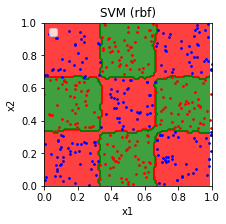

In [38]:
from matplotlib.colors import ListedColormap
X_set, y_set = scaler.inverse_transform(X_test), y_test
X1, X2 = np.meshgrid(np.arange(0,1, step = 0.01),
                     np.arange(0,1, step = 0.01))
plt.figure(figsize=(3,3))

plt.contourf(X1, X2, clf_rbf.predict(scaler.transform(np.array([X1.ravel(), X2.ravel()]).T)).reshape(X1.shape),
             alpha = 0.75, cmap = ListedColormap(('red', 'green')))
plt.scatter(X[y==1,0][:200], X[y==1,1][:200], c='r', s=3)
plt.scatter(X[y==-1,0][:200], X[y==-1,1][:200], c='b', s=3)
plt.xlim([0,1])
plt.ylim([0,1])

# for i, j in enumerate(np.unique(y_set)):
#     plt.scatter(X_set[y_set == j, -1], X_set[y_set == j, 1], c = ListedColormap(('red', 'green'))(i), label = j)
plt.title('SVM (rbf)')
plt.xlabel('x1')
plt.ylabel('x2')
plt.legend()
plt.show()

No handles with labels found to put in legend.


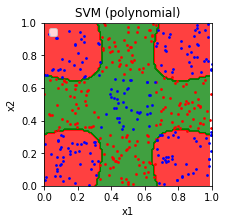

In [39]:
from matplotlib.colors import ListedColormap
X_set, y_set = scaler.inverse_transform(X_test), y_test
X1, X2 = np.meshgrid(np.arange(0,1, step = 0.01),
                     np.arange(0,1, step = 0.01))
plt.figure(figsize=(3,3))

plt.contourf(X1, X2, clf_poly.predict(scaler.transform(np.array([X1.ravel(), X2.ravel()]).T)).reshape(X1.shape),
             alpha = 0.75, cmap = ListedColormap(('red', 'green')))
plt.scatter(X[y==1,0][:200], X[y==1,1][:200], c='r', s=3)
plt.scatter(X[y==-1,0][:200], X[y==-1,1][:200], c='b', s=3)
plt.xlim([0,1])
plt.ylim([0,1])

# for i, j in enumerate(np.unique(y_set)):
#     plt.scatter(X_set[y_set == j, -1], X_set[y_set == j, 1], c = ListedColormap(('red', 'green'))(i), label = j)
plt.title('SVM (polynomial)')
plt.xlabel('x1')
plt.ylabel('x2')
plt.legend()
plt.show()

**Obviously the rbf is a far better fit for this data**

## Optional Reading Materials
1. Shalev-Shwartz, S., Singer, Y., Srebro, N., & Cotter, A. (2011). Pegasos: Primal estimated sub-gradient solver for svm. Mathematical programming, 127(1), 3-30. [[pdf](http://www.ee.oulu.fi/research/imag/courses/Vedaldi/ShalevSiSr07.pdf)]

2. Schölkopf, B., Williamson, R. C., Smola, A. J., Shawe-Taylor, J., & Platt, J. C. (2000). Support vector method for novelty detection. In Advances in neural information processing systems (pp. 582-588). [[pdf](http://papers.nips.cc/paper/1723-support-vector-method-for-novelty-detection.pdf)]

3. Livni, R., Crammer, K. & Globerson, A.. (2012). A Simple Geometric Interpretation of SVM using Stochastic Adversaries. Proceedings of the Fifteenth International Conference on Artificial Intelligence and Statistics, in PMLR 22:722-730. [[pdf](http://proceedings.mlr.press/v22/livni12/livni12.pdf)]

